<a href="https://colab.research.google.com/github/VolkhinD/MRI-Scans/blob/main/madison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Deep Learning for Gastrointestinal Organ Segmentation in Cancer Patients' MRI Scans***

#Project Overview

**Description:**

In this project,I aim to develop an advanced deep learning model for the automatic segmentation of the stomach and intestines in MRI scans of cancer patients. The dataset utilized for this research has been sourced from Kaggle, comprising MRI scans obtained from actual cancer patients who underwent 1-5 scans on separate days during their radiation treatment. The primary objective is to create a robust algorithm that can provide precise segmentation of three crucial components of the digestive system: ***the large bowel, small bowel, and stomach.***

**Clinical Impact:**<sup id="a1">[1](#f1)</sup>

 The successful development of a robust segmentation model holds the potential to significantly impact the care of cancer patients. Accurate delineation of gastrointestinal organs can assist medical professionals in treatment planning, monitoring disease progression, and evaluating the effectiveness of interventions.

In 2019, an estimated 5 million people were diagnosed with a cancer of the gastro-intestinal tract worldwide. Of these patients, about half are eligible for radiation therapy, usually delivered over 10-15 minutes a day for 1-6 weeks. Radiation oncologists try to deliver high doses of radiation using X-ray beams pointed to tumors while avoiding the stomach and intestines. With newer technology such as integrated magnetic resonance imaging and linear accelerator systems, also known as MR-Linacs, oncologists are able to visualize the daily position of the tumor and intestines, which can vary day to day.

In these scans, radiation oncologists must manually outline the position of the stomach and intestines in order to adjust the direction of the x-ray beams to increase the dose delivery to the tumor and avoid the stomach and intestines. This is a time-consuming and labor intensive process that can prolong treatments from 15 minutes a day to an hour a day, which can be difficult for patients to tolerate—unless deep learning could help automate the segmentation process. **A method to segment the stomach and intestines would make treatments much faster and would allow more patients to get more effective treatment.**

What is [MRI](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging)?

Magnetic resonance imaging (MRI) is a medical imaging technique used in radiology to form pictures of the anatomy and the physiological processes of the body. MRI scanners use strong magnetic fields, magnetic field gradients, and radio waves to generate images of the organs in the body.

![MRI](https://www.humonc.wisc.edu/wp-content/uploads/2017/09/Bayouth_Project4_72ppi.png)


**Key Components:**

**MRI Scan Dataset:** The dataset consists of MRI scans obtained from cancer patients, reflecting the dynamic changes in the digestive system during radiation treatment. Each scan is associated with a corresponding segmentation mask indicating the specific regions of the large bowel, small bowel, and stomach.

**Multi-Class Segmentation:** The segmentation task involves identifying and delineating three distinct components within each MRI scan. The model needs to learn the intricate features and patterns that differentiate the large bowel, small bowel, and stomach, ensuring precise segmentation for improved diagnostic and treatment purposes.
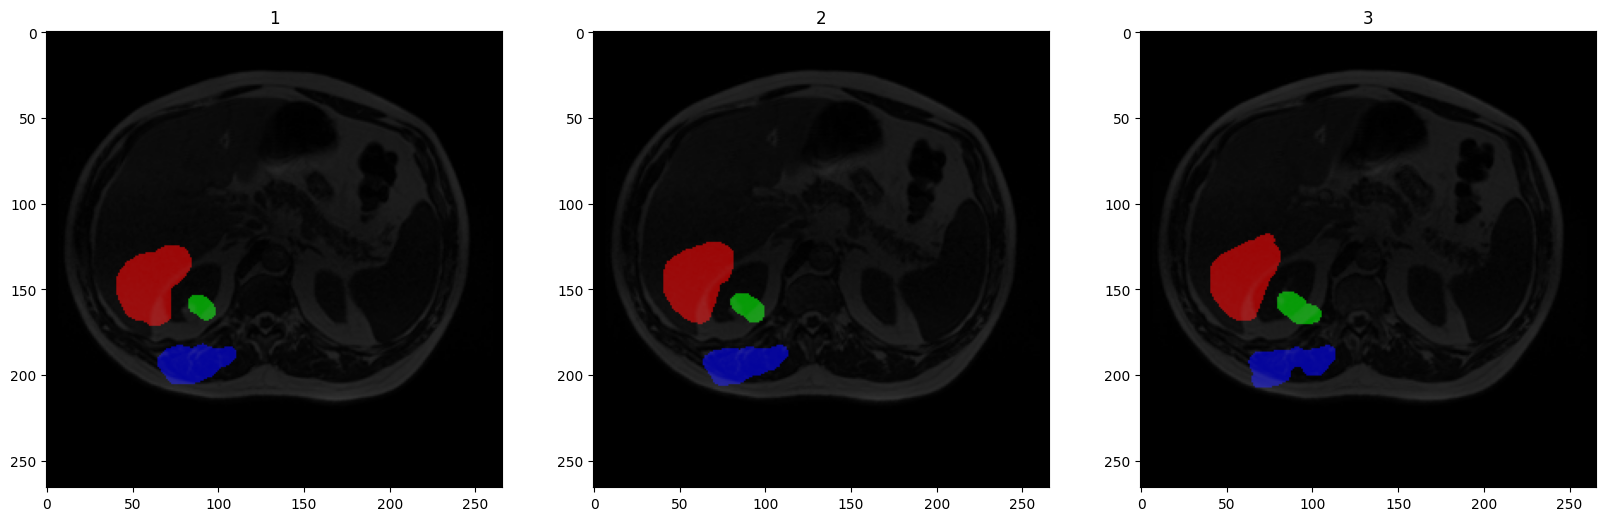

By participating in this competition and contributing novel deep learning solutions, the project aims to advance the field of medical image analysis, ultimately translating into improved outcomes for cancer patients undergoing radiation treatment.

Links
1. https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda

# Work with Dataset

# Imports

In [1]:
%%capture
pip install -U git+https://github.com/qubvel/segmentation_models.pytorch;

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import random
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize
import torch.optim as optim
import cv2
import glob
import segmentation_models_pytorch as smp
import albumentations as A
from tqdm import tqdm
import time
import copy
import torchvision.transforms as tf
from sklearn.model_selection import GroupShuffleSplit
import torchvision
from segmentation_models_pytorch.losses import DiceLoss, TverskyLoss
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import seaborn as sns

In [4]:
def set_seed(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()

In [5]:
path = '/content/drive/MyDrive/Data/madison_train.csv'
df = pd.read_csv(path)
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


# Dataset EDA

In [6]:
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [7]:
print(f"Dataset has {df.shape[0]} rows, it can be combied by 3 rows sinse  each 3 rows represent a same case, day and slice. So there are {len(df.id.unique())} unique id")

Dataset has 115488 rows, it can be combied by 3 rows sinse  each 3 rows represent a same case, day and slice. So there are 38496 unique id


## New Columns
Make new colums "large_bowel", "small_bowel" and "stomach"'and create a file path that leads to paticular image, save it to column "path"

In [8]:
c1 = df[df["class"] == "large_bowel"]
c2 = df[df["class"] == "small_bowel"]
c3 = df[df["class"] == "stomach"]
assert c1.id.tolist() == c2.id.tolist()
assert c1.id.tolist() == c3.id.tolist()
c_id = c1.id.tolist()

data = pd.DataFrame.from_dict({
    "id": c_id,
    "large_bowel": c1.segmentation.tolist(),
    "small_bowel": c2.segmentation.tolist(),
    "stomach": c3.segmentation.tolist(),
})


In [9]:
data["id"] = data["id"].astype("str")
data["case_id"] = data["id"].apply(lambda x: x.split("_")[0][4:])
data['day'] = data['id'].apply(lambda x: x.split("_")[1][3:])
data["slice"] = data['id'].apply(lambda x: x.split("_")[3])

In [10]:
root_dir = '/content/drive/MyDrive/Data/madison'
def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    # fetching folder paths
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    # fetching filenames with similar pattern
    file = glob.glob(f"{folder}/{file_starter}*")
    # returning the first file, though it will always hold one file.
    return file[0]
data["path"] = data["id"].apply(lambda x: fetch_file_from_id(root_dir, x))
data.head()

,id,large_bowel,small_bowel,stomach,case_id,day,slice,path
0,case123_day20_slice_0001,NaN,NaN,NaN,123,20,0001,/content/drive/MyDrive/Data/madison/case123/ca...
1,case123_day20_slice_0002,NaN,NaN,NaN,123,20,0002,/content/drive/MyDrive/Data/madison/case123/ca...
2,case123_day20_slice_0003,NaN,NaN,NaN,123,20,0003,/content/drive/MyDrive/Data/madison/case123/ca...
3,case123_day20_slice_0004,NaN,NaN,NaN,123,20,0004,/content/drive/MyDrive/Data/madison/case123/ca...
4,case123_day20_slice_0005,NaN,NaN,NaN,123,20,0005,/content/drive/MyDrive/Data/madison/case123/ca...


In [11]:
data["height"] = data["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype("int")
data["width"] = data["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype("int")
data["number_of_masks"] = 3 - data.isnull().sum(axis=1)
data["number_of_empty_masks"] = data.isnull().sum(axis=1)
data.head(5)

,id,large_bowel,small_bowel,stomach,case_id,day,slice,path,height,width,number_of_masks,number_of_empty_masks
0,case123_day20_slice_0001,NaN,NaN,NaN,123,20,0001,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,0,3
1,case123_day20_slice_0002,NaN,NaN,NaN,123,20,0002,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,0,3
2,case123_day20_slice_0003,NaN,NaN,NaN,123,20,0003,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,0,3
3,case123_day20_slice_0004,NaN,NaN,NaN,123,20,0004,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,0,3
4,case123_day20_slice_0005,NaN,NaN,NaN,123,20,0005,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,0,3


In [12]:
data = data.fillna('')
def count(row):
  if row.large_bowel == '' and row.small_bowel == '' and row.stomach == '':
    return 1
  else:
    return 0

data['all_mask_empty'] = data.apply(count, axis=1)

##Missing Values

<Axes: title={'center': 'How many images per case'}, xlabel='Case #'>

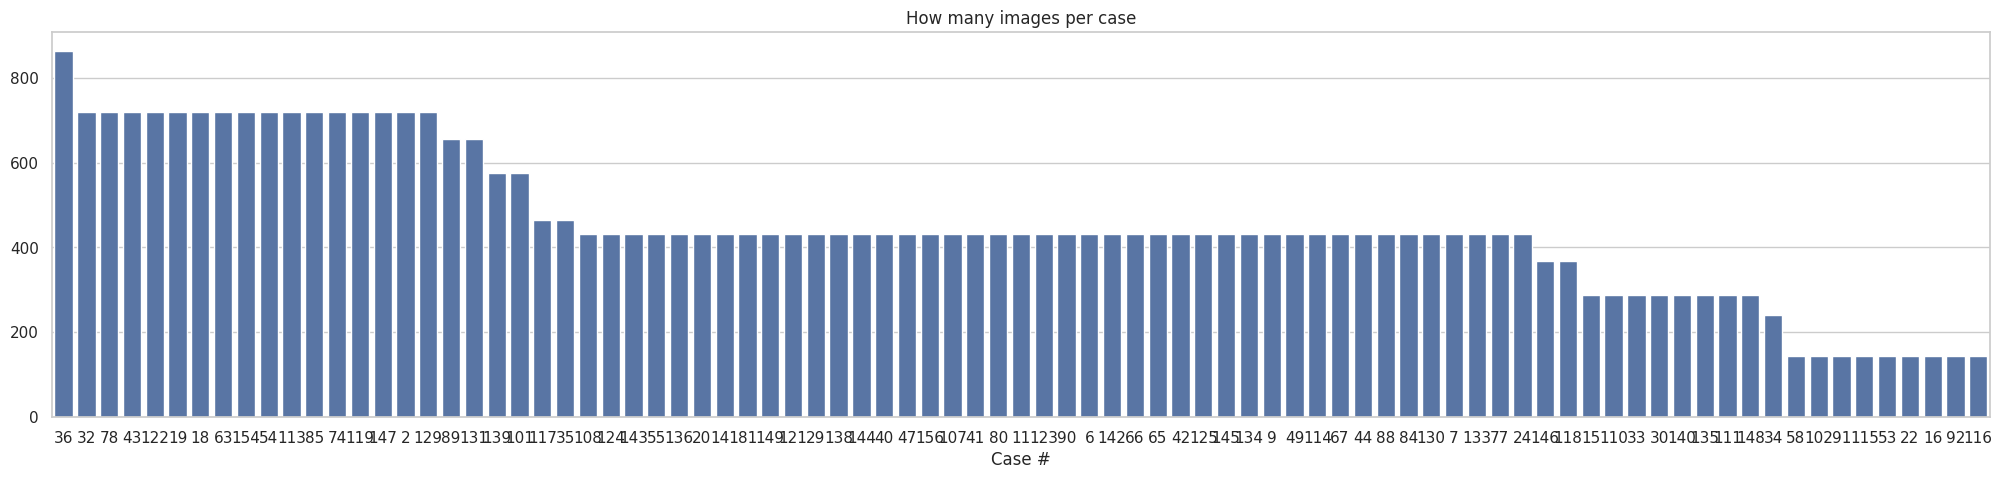

In [13]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(25, 5))
plt.title("How many images per case")

sns.set_color_codes("pastel")
s = data['case_id'].value_counts().rename_axis('Case #')
sns.barplot(x=s.index, y=s.values, order=s.index)


In [14]:
s = s.to_frame().reset_index().rename({"Case #": 'case_id', "case_id": "total"},  axis='columns')

mask_per_case = data.groupby('case_id')['all_mask_empty'].sum().reset_index()

res = pd.merge(s, mask_per_case, on=['case_id']).sort_values("total", ascending=False)
res.head()

,case_id,total,all_mask_empty
0,36,864,427
9,54,720,391
16,129,720,380
15,2,720,345
14,147,720,467


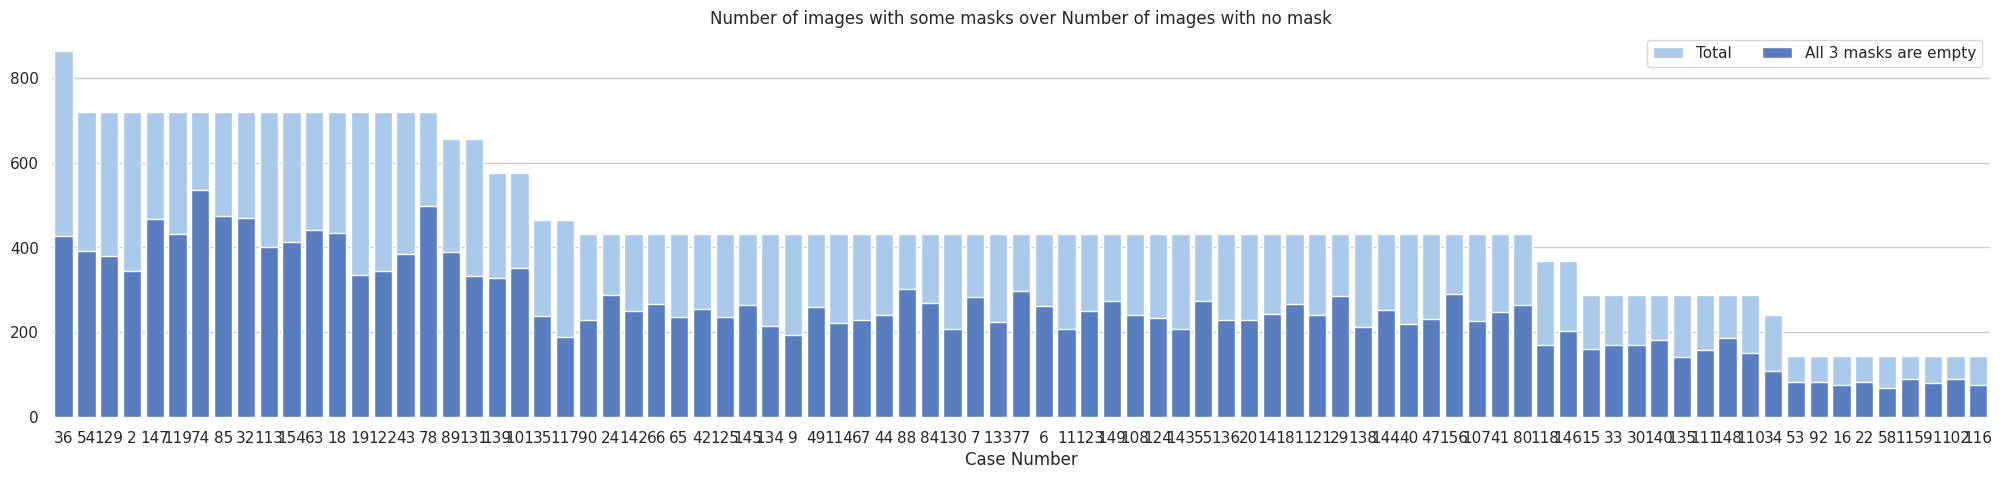

In [15]:

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(25, 5))

# Plot the total images per case
sns.set_color_codes("pastel")
sns.barplot(x="case_id", y="total", data=res,
            label="Total", color="b")

# Plot the empty masks
sns.set_color_codes("muted")
sns.barplot(x="case_id", y="all_mask_empty", data=res,
            label="All 3 masks are empty", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
plt.title("Number of images with some masks over Number of images with no mask")
ax.set(ylabel="",
       xlabel="Case Number")
sns.despine(left=True, bottom=True)


[Text(0, 0, '38496'), Text(0, 0, '38496'), Text(0, 0, '38496')]

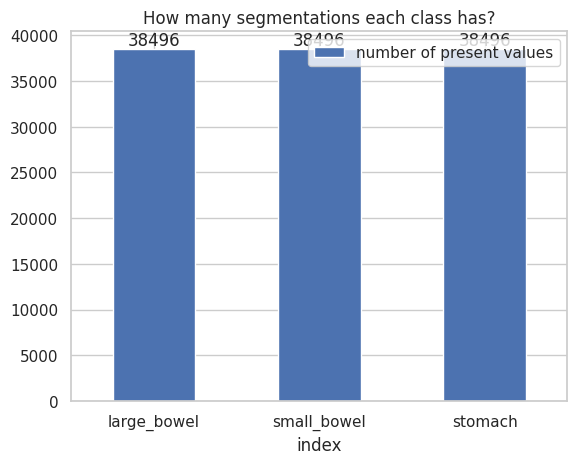

In [16]:
ax = data[["large_bowel", "small_bowel", "stomach"]].notna().sum().reset_index(name="number of present values").plot.bar(x='index', y="number of present values", rot=0, title= "How many segmentations each class has?", sharey=True)

ax.bar_label(ax.containers[0])

In [17]:
"""How many cases have only one segmentation?? only 2?? all 3??? no val at all??"""
data = data.fillna('')
a = data[(data['large_bowel'] == '') & (data['small_bowel'] == '') & (data['stomach'] == '')]
# only 2
b = data[(data['large_bowel'] != '') & (data['small_bowel'] != '') & (data['stomach'] == '')]
c = data[(data['large_bowel'] != '') & (data['small_bowel'] == '') & (data['stomach'] != '')]
d = data[(data['large_bowel'] == '') & (data['small_bowel'] != '') & (data['stomach'] != '')]
# only 1
e = data[(data['large_bowel'] != '') & (data['small_bowel'] == '') & (data['stomach'] == '')]
f = data[(data['large_bowel'] == '') & (data['small_bowel'] != '') & (data['stomach'] == '')]
g = data[(data['large_bowel'] == '') & (data['small_bowel'] == '') & (data['stomach'] != '')]
# all 3
h = data[(data['large_bowel'] != '') & (data['small_bowel'] != '') & (data['stomach'] != '')]
cases = pd.DataFrame.from_dict({"All empty": [len(a), len(data)],  "Only 2 segmentations": [(len(b) + len(c) + len(d)), len(data)], "Only 1 segmentation": [(len(e) + len(f) + len(g)), len(data)], "All 3 segmentation": [len(h), len(data)]})
cases_per_type = pd.DataFrame.from_dict({"Large and Small Bowel": [len(b)], "Large Bowel and Stomach": [len(c)], "Small Bowel and Stomach": [len(d)], "Only Large Bowel": [len(e)], "Only Small Bowel": [len(f)], "Only Stomach": [len(g)], "All 3 Segmentations": [len(h)]})
cases = cases.T.rename({0: "Numbers", 1:'All'}, axis='columns').sort_values(by="Numbers", ascending=False)
cases

,Numbers,All
All empty,21906,38496
Only 2 segmentations,10921,38496
All 3 segmentation,3201,38496
Only 1 segmentation,2468,38496


In [18]:
cat_cases = pd.DataFrame({'Numbers': [len(a), (len(b) + len(c) + len(d)), (len(e) + len(f) + len(g)), len(h)], 'Types': ["All empty","Only 2 segmentations", "All 3 segmentations", "Only 1 segmentation"]})


In [19]:
cases_per_type = cases_per_type.T.rename({0: "Numbers"}, axis='columns').sort_values(by="Numbers", ascending=False)
cases_per_type

,Numbers
Large and Small Bowel,7781
All 3 Segmentations,3201
Large Bowel and Stomach,2980
Only Stomach,2286
Small Bowel and Stomach,160
Only Large Bowel,123
Only Small Bowel,59


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Large and Small Bowel'),
  Text(1, 0, 'All 3 Segmentations'),
  Text(2, 0, 'Large Bowel and Stomach'),
  Text(3, 0, 'Only Stomach'),
  Text(4, 0, 'Small Bowel and Stomach'),
  Text(5, 0, 'Only Large Bowel'),
  Text(6, 0, 'Only Small Bowel')])

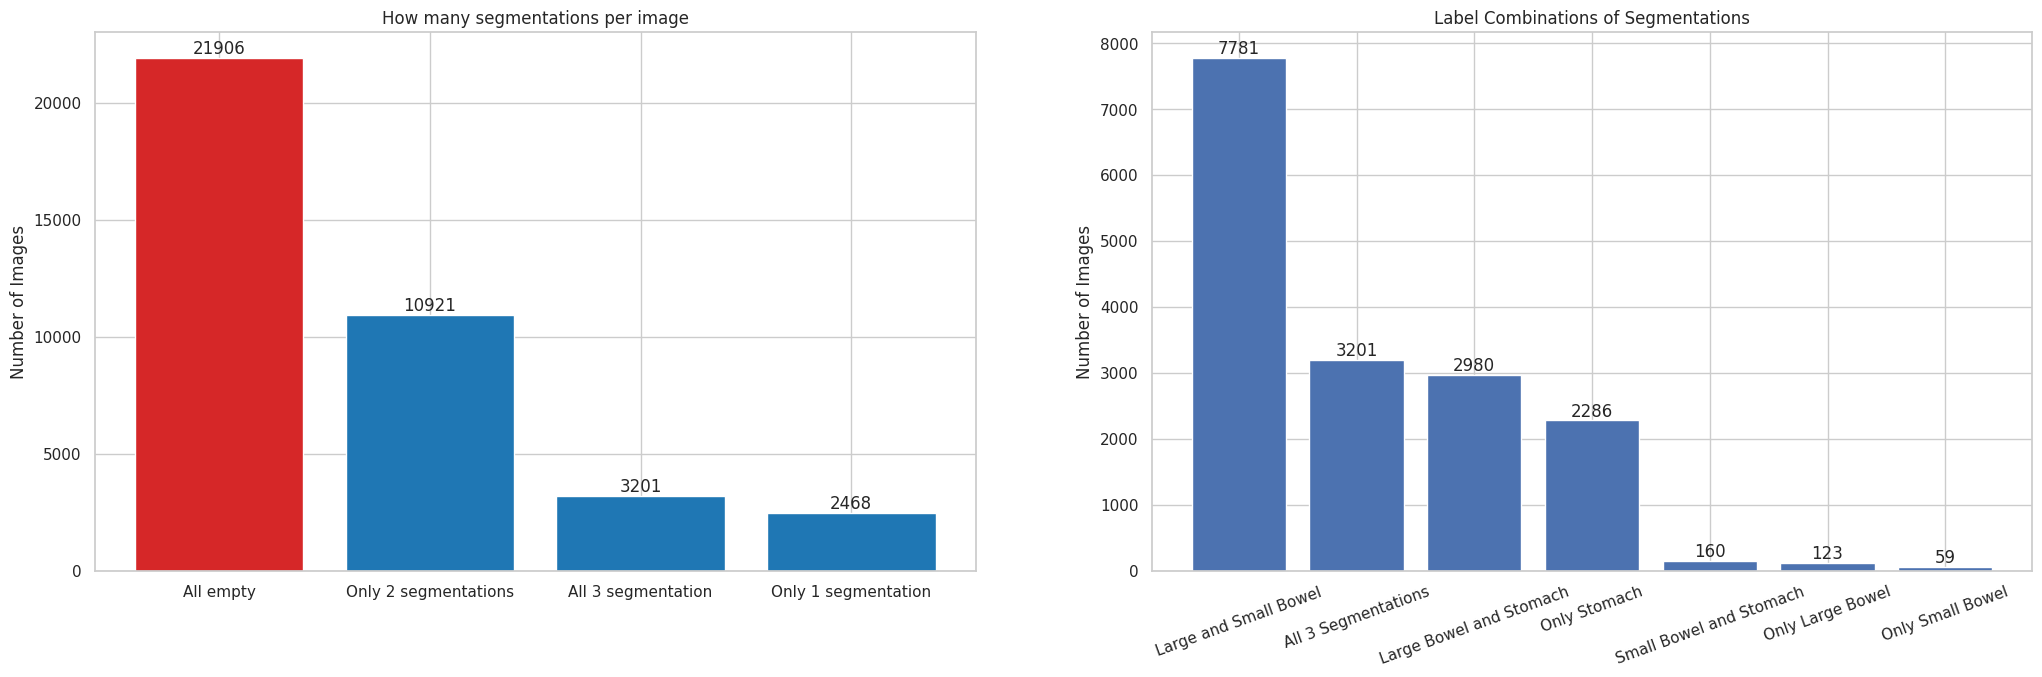

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))
titles = ["How many segmentations per image we have?",
          "   .... "]
bar_colors = ['tab:red', 'tab:blue', 'tab:blue', 'tab:blue']
b_1 =  ax1.bar(cases.index, cases.Numbers, color=bar_colors)
ax1.set_ylabel("Number of Images")
ax1.set_title("How many segmentations per image")
ax1.bar_label(b_1)

b_2 =  ax2.bar(cases_per_type.index, cases_per_type.Numbers)
ax2.set_ylabel("Number of Images")
ax2.set_title("Label Combinations of Segmentations")
ax2.bar_label(b_2)
plt.xticks(rotation=20)

## Remove missing values
Remove all data where all 3 parts don't have masks

In [21]:
data = data.drop(data[(data['large_bowel'] == '') & (data['small_bowel'] == '') & (data['stomach'] == '')].index)
data = data.reset_index(drop=True)

In [22]:
data.sample(5)

,id,large_bowel,small_bowel,stomach,case_id,day,slice,path,height,width,number_of_masks,number_of_empty_masks,all_mask_empty
7764,case7_day0_slice_0085,15515 7 15777 12 16041 14 16306 15 16402 5 165...,,19040 6 19304 9 19568 12 19833 13 20099 14 203...,7,0,0085,/content/drive/MyDrive/Data/madison/case7/case...,266,266,2,1,0
357,case133_day0_slice_0084,31122 5 31480 10 31839 13 32198 15 32558 16 32...,33695 6 34054 8 34397 7 34413 10 34756 9 34773...,,133,0,0084,/content/drive/MyDrive/Data/madison/case133/ca...,360,310,2,1,0
13308,case18_day19_slice_0099,50531 6 50673 7 50889 9 51032 9 51247 12 51391...,36178 7 36537 10 36850 12 36896 12 37205 19 37...,,18,19,0099,/content/drive/MyDrive/Data/madison/case18/cas...,360,310,2,1,0
15582,case41_day32_slice_0094,,,22820 8 23084 12 23349 14 23613 17 23878 19 24...,41,32,0094,/content/drive/MyDrive/Data/madison/case41/cas...,266,266,1,2,0
566,case129_day20_slice_0089,38301 2 38649 15 39006 19 39355 31 39713 34 40...,37948 3 38307 7 38666 14 39026 17 39386 22 397...,,129,20,0089,/content/drive/MyDrive/Data/madison/case129/ca...,360,310,2,1,0


In [23]:
ex_data = data[(data['large_bowel'] != '') & (data['small_bowel'] != '') & (data['stomach'] != '')].reset_index().drop(columns='index')
ex_data.head()

,id,large_bowel,small_bowel,stomach,case_id,day,slice,path,height,width,number_of_masks,number_of_empty_masks,all_mask_empty
0,case123_day20_slice_0082,17481 4 17746 7 18010 10 18275 12 18539 14 188...,22236 2 22500 6 22765 8 23030 10 23296 10 2356...,11052 8 11314 15 11578 19 11843 23 12108 26 12...,123,20,0082,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,3,0,0
1,case123_day20_slice_0083,17480 6 17745 8 18010 11 18275 13 18540 15 188...,22234 6 22499 9 22764 10 23030 11 23296 11 235...,11049 11 11313 16 11577 20 11842 23 12107 26 1...,123,20,0083,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,3,0,0
2,case123_day20_slice_0084,17215 4 17479 8 17745 9 18010 12 18275 14 1854...,21436 4 21701 7 21966 9 22231 11 22497 12 2276...,11045 14 11308 19 11572 23 11838 24 12103 27 1...,123,20,0084,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,3,0,0
3,case123_day20_slice_0085,16950 2 17214 7 17479 10 17491 4 17744 19 1800...,21435 7 21699 10 21965 11 22230 13 22496 14 22...,11043 16 11307 20 11572 23 11837 25 12102 27 1...,123,20,0085,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,3,0,0
4,case123_day20_slice_0086,16949 2 17213 8 17225 4 17478 19 17743 21 1800...,21166 6 21431 8 21660 8 21696 11 21925 10 2196...,11046 11 11307 19 11571 23 11836 25 12101 27 1...,123,20,0086,/content/drive/MyDrive/Data/madison/case123/ca...,266,266,3,0,0


# Configurations

In [48]:
IMG_SIZE = (256, 256)
LR = 0.1
BATCH_SIZE = 16
EPOCHES = 30
IMG_H = 256
IMG_W = 256
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
WEIGHTS = 'imagenet'
ENCODER = "resnet34"

# Create Masks

In [25]:
def rle2mask(rle, imgshape):
    """Function creates 2D mask for only one class
        Used for showing images with mask"""
    width = imgshape[0]
    height= imgshape[1]
    mask = np.zeros( width*height).astype(np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1


    return np.flipud(np.rot90( mask.reshape(height, width), k=1))

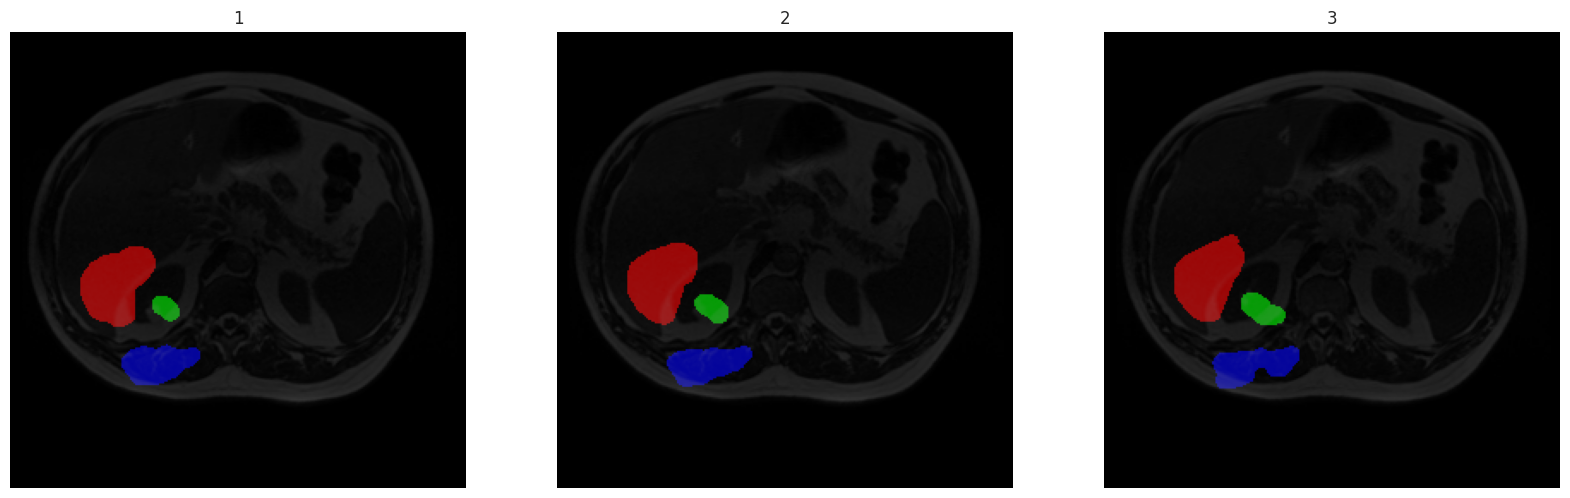

In [26]:
columns = 3
rows = 1
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i).set_title(i)
    img = cv2.imread(ex_data.iloc[i, 7])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask1 = rle2mask(ex_data.iloc[i, 1], (ex_data.iloc[i, 8], ex_data.iloc[i, 9]))
    mask2 = rle2mask(ex_data.iloc[i, 2], (ex_data.iloc[i, 8], ex_data.iloc[i, 9]))
    mask3 = rle2mask(ex_data.iloc[i, 3], (ex_data.iloc[i, 8], ex_data.iloc[i, 9]))
    img[mask1==1,2] = 155
    img[mask2==1,1] = 155
    img[mask3==1,0] = 155
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [27]:
def rle_2D_mask(idx, data):

    """Creates mask for all 3 types
    Used in Dataset class"""

    width = data.iloc[idx, 8]
    height= data.iloc[idx, 9]

    mask = np.zeros(width*height).astype(np.uint8)

    for i in range(1, 4):
        rle = data.iloc[idx, i]
        if rle:
            array = np.asarray([int(x) for x in rle.split()])
            starts = array[0::2]
            lengths = array[1::2]

            for index, start in enumerate(starts):
                mask[int(start):int(start+lengths[index])] = i


    return np.flipud(np.rot90(mask.reshape(height, width), k=1))

Just checking if it works corectly

<ipython-input-28-ef23f83f4b7b>:2: RuntimeWarning: divide by zero encountered in floor_divide
  example_mask = np.where(ex_mask > 0, 255 // ex_mask, 0)


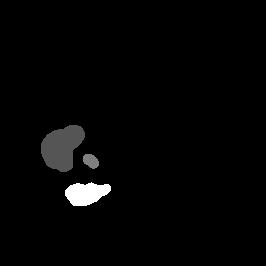

In [28]:
ex_mask = rle_2D_mask(1, ex_data)
example_mask = np.where(ex_mask > 0, 255 // ex_mask, 0)
ex = Image.fromarray(example_mask)
ex

# Augmentations

In [29]:
def get_train_aug():
    return A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.VerticalFlip(0.5)], is_check_shapes=False
                    )
def get_valid_aug():
    return A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1])
        ], is_check_shapes=False
                    )

# Create Dataset

In [30]:
class MyDataset(Dataset):
    def __init__(self, csv_file, augmentations=None):
        self.csv_file = csv_file
        self.height = self.csv_file['height'].tolist()
        self.width = self.csv_file['width'].tolist()
        self.augmentations = augmentations

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):

        image_path = self.csv_file.iloc[idx, 7]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = rle_2D_mask(idx, self.csv_file)

         # to make mask (h, w, c) where c = 1
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # from (h, w, c) change to (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.from_numpy(mask)
        mask = mask.to(torch.long) # remove it to see mask


        # labels = torch.tensor(num_obj)


        return image, mask

In [31]:
ex = MyDataset(data, get_train_aug())[153]


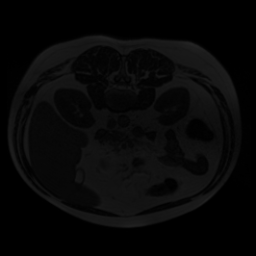

In [32]:
import torchvision.transforms as T
transform = T.ToPILImage()
img = transform(ex[0])
img

In [33]:
# m = transform(ex[1])
# m

# Split Dataset and Create Dataloaders

In [34]:
splitter = GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 7)
split = splitter.split(data, groups=data.case_id)
train_inds, test_inds = next(split)

train = data.iloc[train_inds]
test = data.iloc[test_inds]

In [35]:
train_set = MyDataset(train, get_train_aug())
valid_set = MyDataset(test, get_valid_aug())

In [36]:
print(f"Total number of images in train dataset is {train.shape[0]}")
print(f"Total number of images in valid dataset is {test.shape[0]}")

Total number of images in train dataset is 13963
Total number of images in valid dataset is 2627


In [37]:
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE)
validloader = DataLoader(valid_set, batch_size=BATCH_SIZE)

print(f"Total number of batches in train loader is {len(trainloader)}")
print(f"Total number of batches in validation loader is {len(validloader)}")

Total number of batches in train loader is 873
Total number of batches in validation loader is 165


In [38]:
images, masks = next(iter(trainloader))
print(f"One image Batch shape is {images.size()}")
print(f"One mask batch shape is {masks.size()}")

One image Batch shape is torch.Size([16, 3, 256, 256])
One mask batch shape is torch.Size([16, 1, 256, 256])


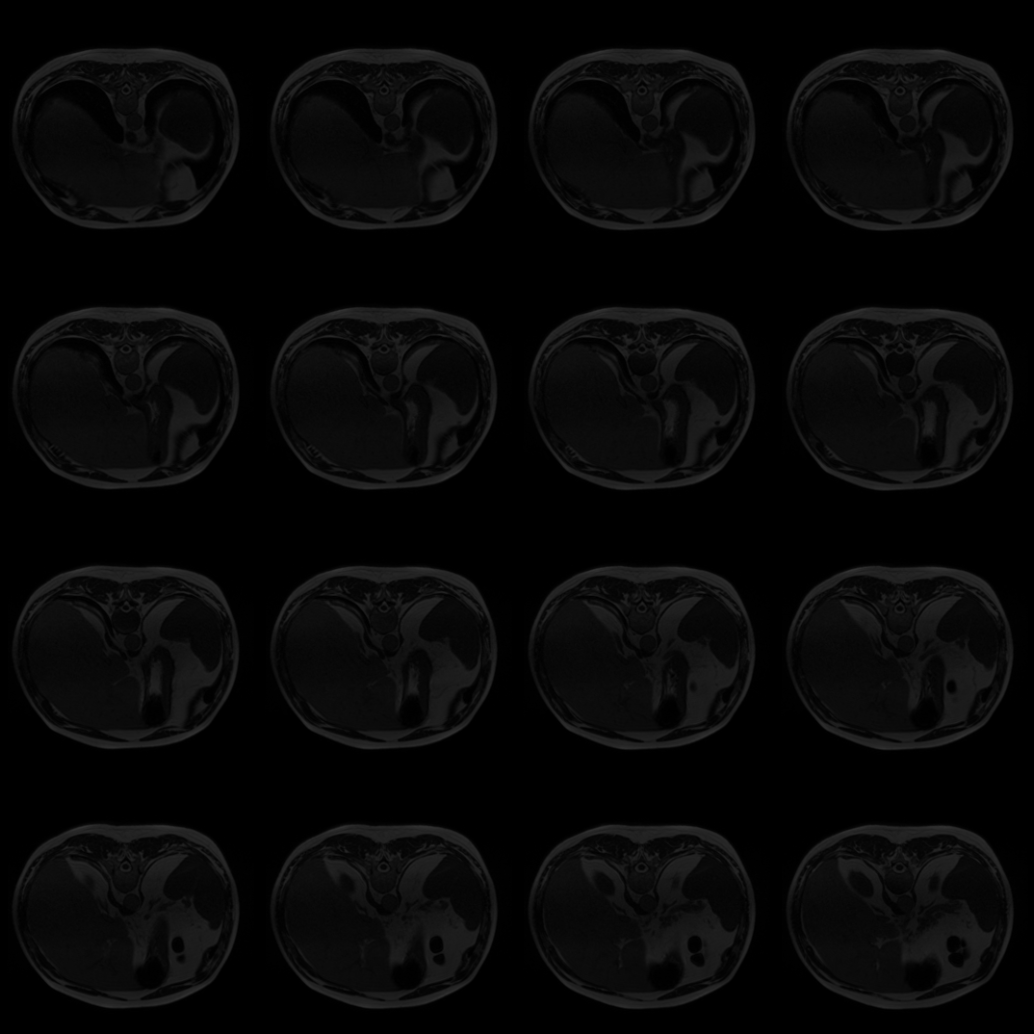

In [39]:
input_grid = torchvision.utils.make_grid(images, nrow=4)
t2img = T.ToPILImage()
t2img(input_grid)

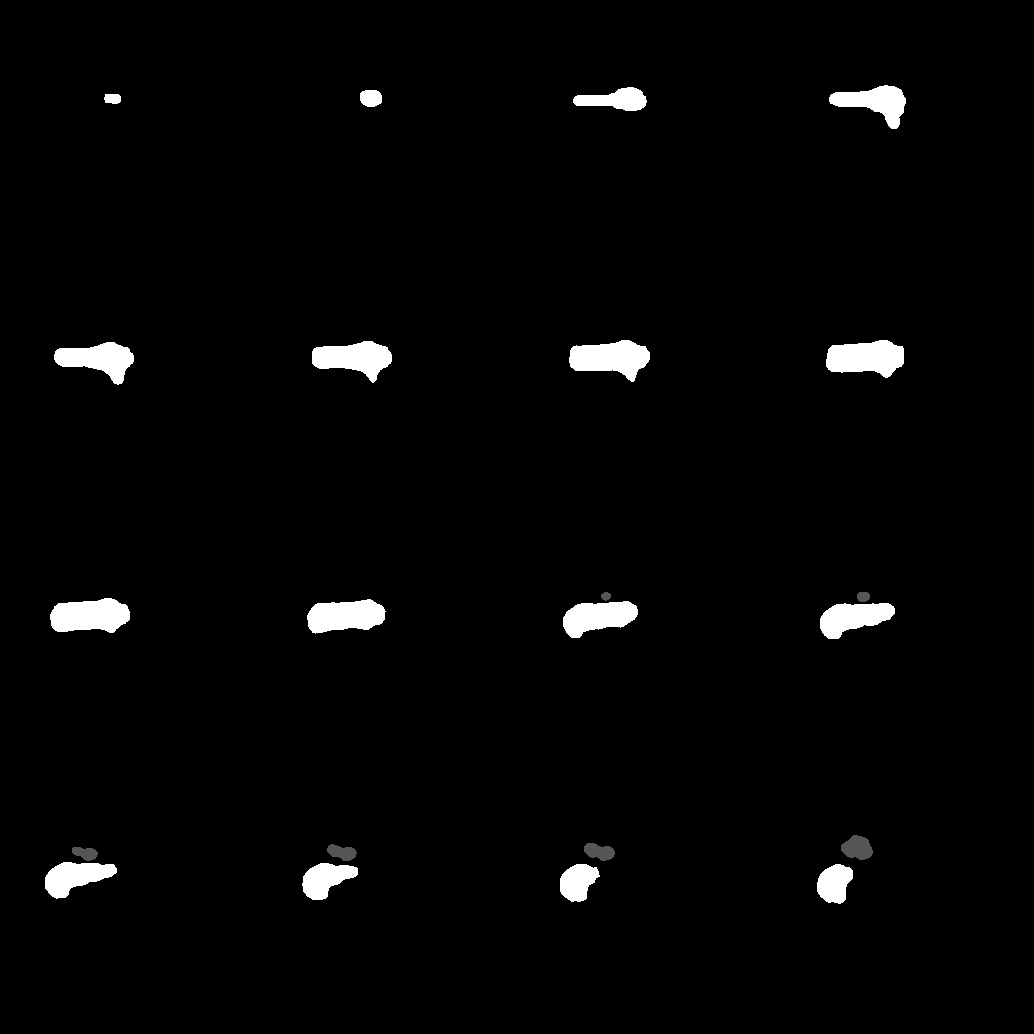

In [40]:
targets_grid = torchvision.utils.make_grid(masks / 3, nrow=4)
t2img(targets_grid)

# Create Segmentation Model

In [41]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.arc = smp.Linknet(
        encoder_name = ENCODER,
        encoder_weights=WEIGHTS,
        in_channels = 3,
        classes = 4,
        activation = None)

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='multiclass')(logits, masks)
      loss2 = TverskyLoss(mode='multiclass')(logits, masks)
      return logits, loss1 + loss2

    return logits

In [42]:
model = UNet()
model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 316MB/s]


# Train and Validation Function

In [43]:
def train_fn(data_loader, model, optimizer):

    model.train()
    total_loss = 0

    for img, mask in tqdm(data_loader):
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)

        optimizer.zero_grad()
        out, loss = model(img, mask)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

In [44]:
def eval_fn(data_loader, model):

    model.eval() # no dropout levels
    total_loss = 0
    iou_accuracies = []

    with torch.no_grad():
        for img, mask in tqdm(data_loader):
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)
            predictions, loss = model(img, mask)
            total_loss += loss.item()
            pred_probabilities = nn.Softmax(dim=1)(predictions)
            pred_labels = predictions.argmax(dim=1)
            mask = mask.squeeze(1)
            tp, fp, fn, tn = smp.metrics.get_stats(pred_labels, mask, mode='multiclass', num_classes=5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
          # # Add a value 1 dimension at dim=1
          # pred_labels = pred_labels.unsqueeze(1)
          # # print("pred_labels.shape: {}".format(pred_labels.shape))
          # pred_mask = pred_labels.to(torch.float)
          # iou = IoUMetric(pred_probabilities, mask, False)
            iou_accuracies.append(iou_score.item())

    iou_tensor = torch.FloatTensor(iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"IoU Mean is {iou_tensor.mean():.4f}" )

    return total_loss/len(data_loader), iou_tensor.mean()

In [45]:
# img, mask = next(iter(trainloader))
# img, mask = img.to(DEVICE), mask.to(DEVICE)
# predictions, loss = model(img, mask)
# pred_probabilities = nn.Softmax(dim=1)(predictions)
# pred_labels = predictions.argmax(dim=1)
# mask = mask.squeeze(1)
# tp, fp, fn, tn = smp.metrics.get_stats(pred_labels, mask, mode='multiclass', num_classes=5)
# iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
# iou_score

# Train Model

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0 = 5,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-4)

In [50]:
best_val_loss = np.Inf
best_iou = 0
for i in range(EPOCHES):
  train_loss = train_fn(trainloader, model, optimizer)
  scheduler.step()
  valid_loss, iou = eval_fn(validloader, model)

  if iou > best_iou:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Models/madison_best_model.pt')
    print("MODEL SAVED")
    best_iou = iou

  print(f"Epoch : {i + 1} Train Loss: {train_loss:.3f} Validation Loss: {valid_loss:.3f}")

100%|██████████| 165/165 [20:40<00:00,  7.52s/it]


Test Dataset Accuracy
IoU Mean is 0.3973
MODEL SAVED
Epoch : 1 Train Loss: 1.209 Validation Loss: 1.281


  3%|▎         | 24/873 [00:09<05:24,  2.62it/s]


KeyboardInterrupt: 

I stop learning cause it's working too slow, I need to wait for holidays

# Evaluate Model

In [51]:
idx = 15
model.load_state_dict(torch.load('/content/drive/MyDrive/Models/madison_best_model.pt'))

<All keys matched successfully>

In [52]:
def decode_segmap(image, nc=5):
  label_colors = np.array([(0, 0, 0),  # 0=background
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb

def show_model_output(idx, model):

  img, mask = valid_set[idx]
  img, mask = img.to(DEVICE).unsqueeze(0), mask.to(DEVICE) # (c, h, w) -> (1, c, h, w)
  out = model(img)
  pred = nn.Softmax(dim=1)(out)
  pred_mask = pred.argmax(dim=1).squeeze().cpu().numpy()

  print(f"Predicted classes {np.unique(pred_mask)}")

  rgb_pred_mask = decode_segmap(pred_mask)

  mask = mask.squeeze().cpu().numpy()
  print(f"Original classes {np.unique(mask)}")
  rgb_orig_mask = decode_segmap(mask)

  img = img.squeeze().permute(1, 2, 0).cpu()



  fig = plt.figure(figsize=(20, 4))
  fig.suptitle("Model Results for One Image", fontsize=12)

  fig.add_subplot(1, 3, 1)
  plt.imshow(img)
  plt.axis('off')
  plt.title("Image")

  fig.add_subplot(1, 3, 2)
  plt.imshow(rgb_orig_mask)
  plt.axis('off')
  plt.title("Original Mask")

  fig.add_subplot(1, 3, 3)
  plt.imshow(rgb_pred_mask)
  plt.axis('off')
  plt.title("Predicted Mask")

  plt.show()



Predicted classes [0 1 2 3]
Original classes [0 2 3]


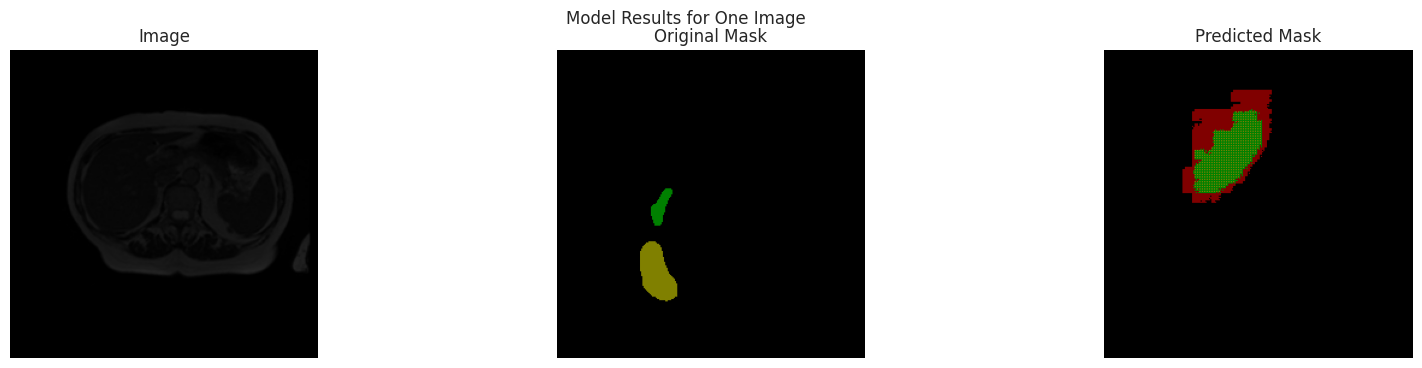

In [53]:
show_model_output(idx, model)